This will be a notebook for investigating the \[\[7,1,3\]\] color code. This is a 2D color code. I will be using the paper from quantinuum for references to quantum circuits. \
We can first start by preparing the logical qubit basis state. This circuit will prepare the logical basis state $\ket{0}_L$ which corresponds to the state/code word:
$$ \ket{0}_L = \frac{1}{\sqrt{8}}\left(\ket{0000000> + |1010101> + |0110011> + |1100110> + |0001111> + |1011010> + |0111100> + |1101001}\right)$$

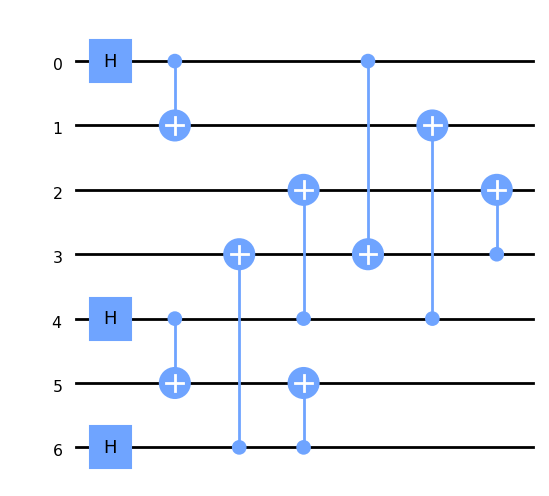

In [30]:
# encoding circuit to create the logical basis states
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

qreg_q = QuantumRegister(7, '')

encodingcircuit = QuantumCircuit(qreg_q)

encodingcircuit.h(qreg_q[0])
encodingcircuit.h(qreg_q[4])
encodingcircuit.h(qreg_q[6])
encodingcircuit.cx(qreg_q[0], qreg_q[1])
encodingcircuit.cx(qreg_q[4], qreg_q[5])
encodingcircuit.cx(qreg_q[6], qreg_q[3])
encodingcircuit.cx(qreg_q[4], qreg_q[2])
encodingcircuit.cx(qreg_q[6], qreg_q[5])
encodingcircuit.cx(qreg_q[0], qreg_q[3])
encodingcircuit.cx(qreg_q[4], qreg_q[1])
encodingcircuit.cx(qreg_q[3], qreg_q[2])
encodingcircuit.draw('mpl')
#@columns [0,0,0,1,1,2,3,3,4,5,6]

This circuit was taken from the paper from Quantinuum. Note that the 8th qubit and CNOTS going to it are for measuring the encoded state. \
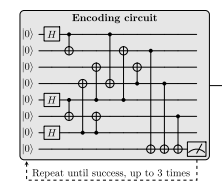 \
We can now measure the encoded state using the rest of the circuit given to see what values result. However we first want to create a general gate that represents the encoding circuit so we can append other quantum circuits to it: 

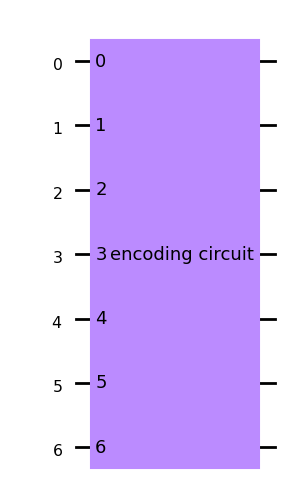

In [31]:
encodeGate = encodingcircuit.to_instruction(label='encoding circuit')

testcircuit = QuantumCircuit(qreg_q)
testcircuit.append(encodeGate, qreg_q) # add the encoding circuit to the new circuit
testcircuit.draw('mpl')

Lets test this circuit to make sure it outputs the desired statevector/code word:

In [54]:
from qiskit.quantum_info import Operator, Statevector

import numpy as np
from scipy import sparse

encodingOperator = Operator(encodingcircuit) # compile encoding circuit into single operator
statevec = Statevector(QuantumCircuit(7)) # create statevector with 7 qubits
statevec = statevec.evolve(encodingOperator) # evolve statevector using encoding operator

# the statevector is very sparse, so we use a sparse matrix
# resepresentation in such cases to speed up calculations
# statevec_spmatrix = np.array(statevec).to_spmatrix()
statevec_spmatrix = sparse.csr_matrix(np.array(statevec))
indices = sparse.find(statevec_spmatrix)[1]
values = np.abs(sparse.find(statevec_spmatrix)[2])
print(indices)
print(values)

# quick script to convert the indices to their binary representation:
expected_reprs = ["0000000", "1010101", "0110011", "1100110", "0001111", "1011010", "0111100", "1101001"]

bin_indices = []
bin_reprs = []
for i in indices:
    bin_indices = np.append(bin_indices, bin(i))
    bin_repr = np.binary_repr(i,7)
    print(f"{bin_repr} ({'' if bin_repr in expected_reprs else 'not'} in expected logical state)")

[  0  15  54  57  85  90  99 108]
[0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]
0000000 ( in expected logical state)
0001111 ( in expected logical state)
0110110 (not in expected logical state)
0111001 (not in expected logical state)
1010101 ( in expected logical state)
1011010 ( in expected logical state)
1100011 (not in expected logical state)
1101100 (not in expected logical state)


Curiously, it seems that some of the resultant states don't match up with the ones composing the logical $\ket{0_L}$. A good sanity check for something like this is to check if it is an eigenvector of the stabilizers. 
 

XXXXIII (logical state is not an eigenstate)
IXXIXXI (logical state is not an eigenstate)
IIXXIXX (logical state is not an eigenstate)
ZZZZIII (logical state is an eigenstate)
IZZIZZI (logical state is an eigenstate)
IIZZIZZ (logical state is an eigenstate)


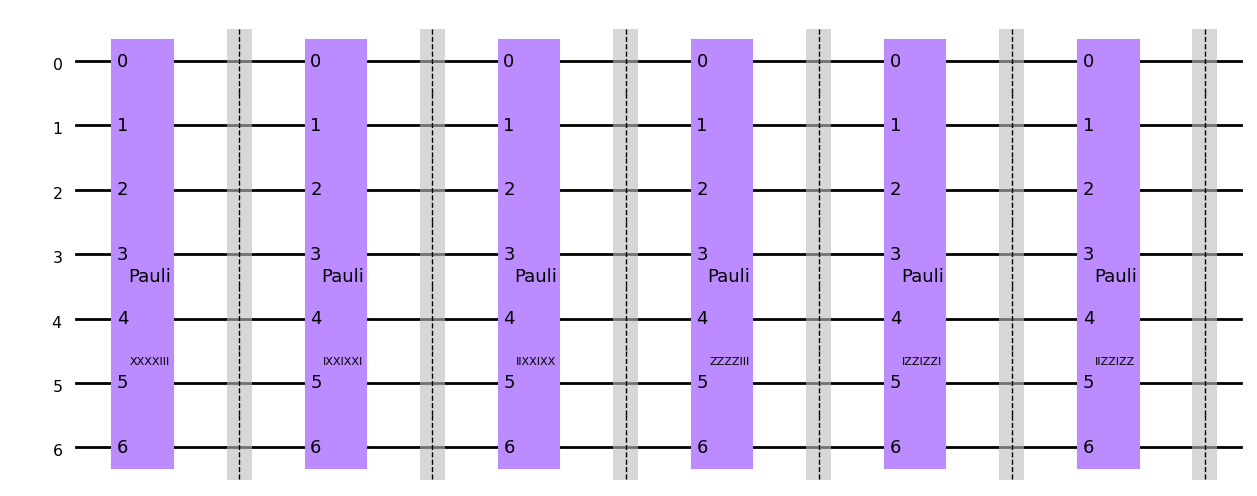

In [61]:
stabilizer_strings = [
    "XXXXIII",
    "IXXIXXI",
    "IIXXIXX",
    "ZZZZIII",
    "IZZIZZI",
    "IIZZIZZ"
]

stabilizer_operators = []

compiled_stabilizercircuit = QuantumCircuit(qreg_q)
for stabilizer_string in stabilizer_strings:
    encodingOperator = Operator(stabilizercircuit)
    stabilizercircuit = QuantumCircuit(qreg_q)
    stabilizercircuit.pauli(stabilizer_string, [q for q in range(len(qreg_q))])
    stabilizercircuit.barrier(qreg_q)

    # check that logical zero vector is an eigenstate of this stabilizer
    stabilizer_operator = Operator(stabilizercircuit)
    test_statevec = Statevector(QuantumCircuit(7)) # zero statevector
    test_statevec.evolve(encodingOperator) # encode
    tested_statevec = test_statevec.evolve(stabilizer_operator) # apply this stabilizer
    print(f"{stabilizer_string} (logical state is {'' if tested_statevec.equiv(test_statevec) else 'not '}an eigenstate)")

    compiled_stabilizercircuit &= stabilizercircuit

compiled_stabilizercircuit.draw("mpl")

Now we can measure the encoding circuit using the 3 CNOTs. This constitutes a measurement in the logical Z basis.

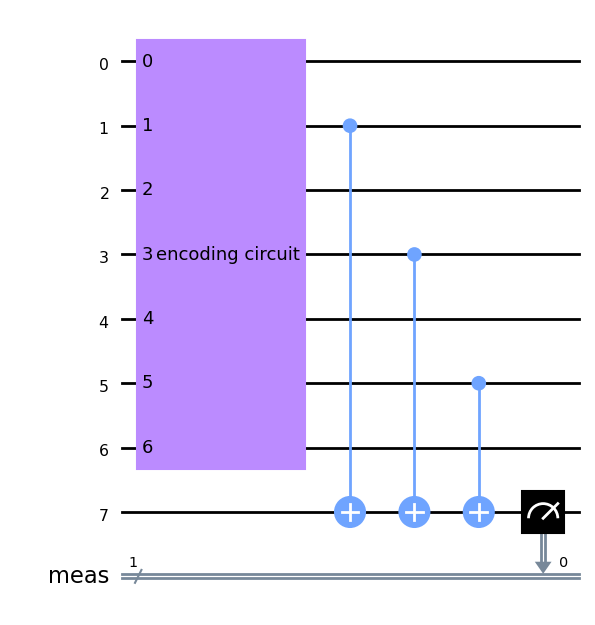

In [ ]:
qreg_m = QuantumRegister(8, '')
creg_m = ClassicalRegister(1, name='meas')
meascircuit = QuantumCircuit(qreg_m, creg_m)
meascircuit.append(encodeGate, qreg_m[:7])
meascircuit.cx(control_qubit=qreg_m[1], target_qubit=qreg_m[7])
meascircuit.cx(control_qubit=qreg_m[3], target_qubit=qreg_m[7])
meascircuit.cx(control_qubit=qreg_m[5], target_qubit=qreg_m[7])
meascircuit.measure(7, 0)
meascircuit.draw('mpl')